In [ ]:
import os
import sys
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.models as models

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report, roc_curve


using_platform = 'colab'

dataset_path = None
if using_platform == 'colab':
    from google.colab import drive
    import kagglehub
    drive.mount('/content/drive')
    sys.path.append('/content/drive/My Drive/COMP4471/Project')
    dataset_path = kagglehub.dataset_download("jagachau/weather-dataset")
    dataset_path = os.path.join(dataset_path, 'weather_dataset')
elif using_platform == 'kaggle':
    dataset_path = '/kaggle/input/weather-dataset/weather_dataset'
else:
    print('invalid platform')

print('dataset path:', dataset_path)

seed = 4471
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# For precise error position
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)
print('GPU count:', torch.cuda.device_count())

Mounted at /content/drive


100%|██████████| 678M/678M [00:33<00:00, 21.0MB/s]

Extracting files...


dataset path: /root/.cache/kagglehub/datasets/jagachau/weather-dataset/versions/1/weather_dataset
using device: cuda
GPU count: 1


In [ ]:
all_classes = os.listdir(dataset_path)

grouped_classes = {
    'foggy': ['fogsmog', 'sandstorm'],
    'cold': ['snow', 'rime', 'frost', 'glaze'],
    'cloudy': ['cloudy'],
    'dew': ['dew'],
    'hail': ['hail'],
    'lightning': ['lightning'],
    'rain': ['rain'],
    'shine': ['shine'],
    'sunrise': ['sunrise']
}

classes = list(grouped_classes.keys())
num_classes = len(classes)

print(classes)

['foggy', 'cold', 'cloudy', 'dew', 'hail', 'lightning', 'rain', 'shine', 'sunrise']


Number of images per weather type:
foggy: 1543
cold: 2895
cloudy: 300
dew: 698
hail: 591
lightning: 377
rain: 973
shine: 253
sunrise: 357


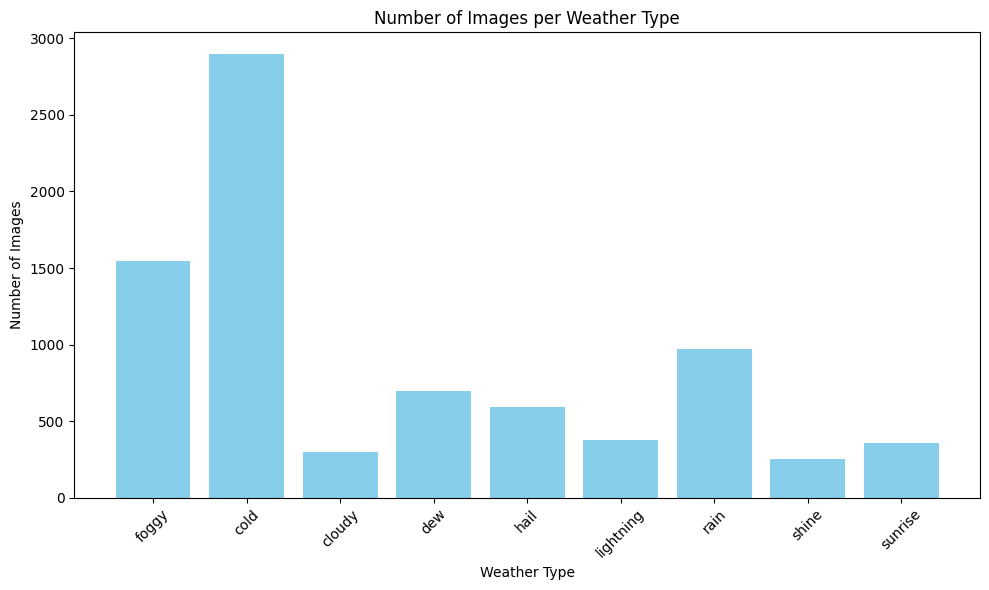

In [ ]:
class_counts = {}
for weather_type, subclasses in grouped_classes.items():
    total = 0
    for subclass in subclasses:
        class_path = os.path.join(dataset_path, subclass)
        if os.path.exists(class_path):
            total += len(os.listdir(class_path))
    class_counts[weather_type] = total

print("Number of images per weather type:")
for weather_type, count in class_counts.items():
    print(f"{weather_type}: {count}")

# Plot a bar chart for the number of each weather type
weather_types = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(weather_types, counts, color='skyblue')
plt.xlabel('Weather Type')
plt.ylabel('Number of Images')
plt.title('Number of Images per Weather Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
class GroupedDataset(Dataset):
    def __init__(self, original_dataset, grouped_targets, grouped_classes):
        self.dataset = original_dataset
        self.targets = grouped_targets
        self.classes = grouped_classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Get the image and ignore the original label
        target = self.targets[idx]  # Use the grouped label
        return img, target

def split_dataset(altered_dataset, original_dataset, train_ratio=0.8, batch_size=64):
  workers = torch.cuda.device_count() * 2 if torch.cuda.device_count() else 1
  targets = np.array(altered_dataset.targets)

  # Split per class
  train_indices = []
  val_indices = []

  for class_idx in range(len(classes)):
    class_indices = np.where(targets == class_idx)[0]
    class_size = len(class_indices)

    train_size = int(train_ratio * class_size)

    train_idx, val_idx = train_test_split(
        class_indices,
        train_size=train_size,
        random_state=seed
    )

    train_indices.extend(train_idx)
    val_indices.extend(val_idx)

  train_dataset = Subset(altered_dataset, train_indices)
  val_dataset = Subset(original_dataset, val_indices)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

  print(f"Train set size: {len(train_dataset)}")
  print(f"Validation set size: {len(val_dataset)}")

  return train_loader, val_loader


# Map original classes to grouped classes
def map_to_grouped_class(label, class_to_group):
    for group, original_classes in class_to_group.items():
        if label in original_classes:
            return group
    return label

# Create a new dataset with grouped labels
def create_grouped_dataset(dataset, class_to_group):
    grouped_targets = [
        map_to_grouped_class(dataset.classes[label], class_to_group) for label in dataset.targets
    ]
    grouped_classes = list(class_to_group.keys())
    grouped_class_to_idx = {cls: idx for idx, cls in enumerate(grouped_classes)}
    grouped_targets = [grouped_class_to_idx[label] for label in grouped_targets]
    return GroupedDataset(dataset, grouped_targets, grouped_classes)

In [ ]:
resnet_mean = [0.485, 0.456, 0.406]
resnet_sd = [0.229, 0.224, 0.225]

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), 
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.RandomResizedCrop(size=224, scale=(0.85, 1.0)), 
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

altered_dataset = dset.ImageFolder(root=dataset_path, transform=transform_train)
original_dataset = dset.ImageFolder(root=dataset_path, transform=transform_val)

altered_dataset = create_grouped_dataset(altered_dataset, grouped_classes)
original_dataset = create_grouped_dataset(original_dataset, grouped_classes)
print(original_dataset.classes)

train_loader, val_loader = split_dataset(altered_dataset, original_dataset, 0.8, 128)

['foggy', 'cold', 'cloudy', 'dew', 'hail', 'lightning', 'rain', 'shine', 'sunrise']
Train set size: 6386
Validation set size: 1601


In [ ]:
def get_model():
	model = models.resnet152(weights='DEFAULT')

	# Change the output layer to number of classes
	num_features = model.fc.in_features
	model.fc = nn.Linear(num_features, num_classes)
	model.to(device)

	for param in model.parameters():
		param.requires_grad = False
	for param in model.fc.parameters():
		param.requires_grad = True

	return model

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=10, criterion=nn.CrossEntropyLoss()):
	train_losses, val_losses = [], []
	train_accs, val_accs = [], []

	for e in range(epochs):
		# Training
		model.train()
		train_loss = 0.0
		correct = 0
		total = 0
		batch_bar = tqdm(train_loader, desc=f"Epoch {e+1}: Train")
		for x, y in batch_bar:
			x, y = x.to(device), y.to(device)

			scores = model(x)
			loss = criterion(scores, y)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			train_loss += loss.item()
			_, predicted = torch.max(scores, 1)
			total += y.size(0)
			correct += (predicted == y).sum().item()

			batch_acc = 100 * correct / total
			batch_bar.set_postfix({"Train loss": f"{train_loss/len(batch_bar):.4f}", "Train acc": f"{batch_acc:.2f}%"})

		scheduler.step()
		train_acc = 100 * correct / total
		train_accs.append(train_acc)
		avg_train_loss = train_loss / len(train_loader)
		train_losses.append(avg_train_loss)

		# Validation
		model.eval()
		val_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():  # No gradients during validation
			batch_bar = tqdm(val_loader, desc=f"Epoch {e+1}: Validation")
			for x, y in batch_bar:
					x, y = x.to(device), y.to(device)
					scores = model(x)
					loss = criterion(scores, y)
					val_loss += loss.item()
					_, predicted = torch.max(scores, 1)
					total += y.size(0)
					correct += (predicted == y).sum().item()
					batch_acc = 100 * correct / total
					batch_bar.set_postfix({"Val loss": f"{val_loss/len(batch_bar):.4f}", "Val acc": f"{batch_acc:.2f}%"})

		val_acc = 100 * correct / total
		val_accs.append(val_acc)
		avg_val_loss = val_loss / len(val_loader)
		val_losses.append(avg_val_loss)

	return train_losses, val_losses, train_accs, val_accs

def loss_acc_plot(train_losses, val_losses, train_accs, val_accs):
	# Plot loss
	plt.figure(figsize=(8, 6))
	plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
	plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Training and Validation Loss')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# Plot accuracy
	plt.figure(figsize=(8, 6))
	plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', marker='o')
	plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', marker='o')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')
	plt.title('Training and Validation Accuracy')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def inference(model, loader):
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc='Inference'):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	test_acc = 100 * correct / total
	print(f"Accuracy: {test_acc:.2f}%")

def get_predictions_and_probs(model, loader):
	model.eval()
	all_labels, all_preds, all_probs = [], [], []
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc="Loading"):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			probs = torch.softmax(outputs, dim=1)
			_, preds = torch.max(probs, 1)
			all_labels.extend(labels.cpu().numpy())
			all_preds.extend(preds.cpu().numpy())
			all_probs.extend(probs.cpu().numpy())
	return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def get_class_weights(class_counts):
	class_counts = np.array(class_counts)
	class_weights = 1.0 / class_counts
	class_weights = class_weights / class_weights.sum() * len(class_counts)
	return torch.tensor(class_weights, dtype=torch.float32, device=device)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 225MB/s] 
Epoch 30: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, Val loss=0.2171, Val acc=94.00%]


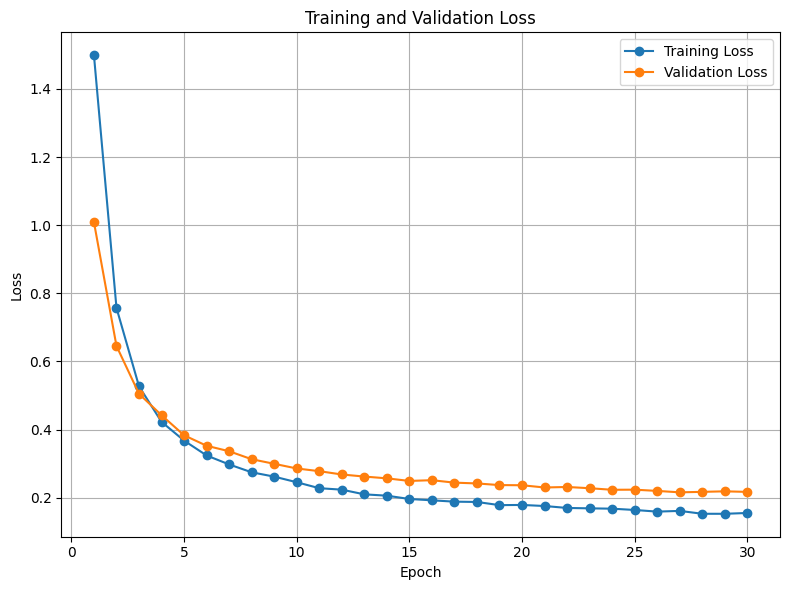

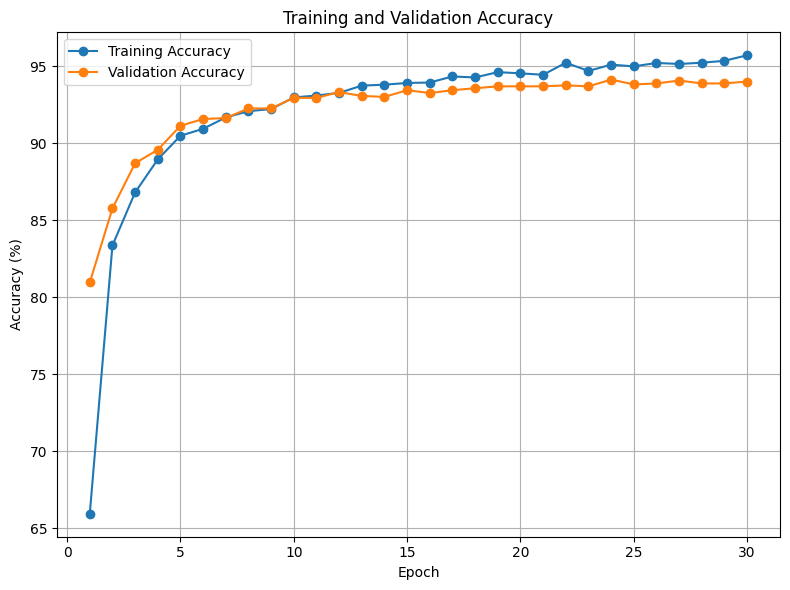

In [ ]:
epochs = 30
learning_rate = 5e-4

model = get_model()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

class_weights = get_class_weights(list(class_counts.values()))
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs, criterion)

loss_acc_plot(train_losses, val_losses, train_accs, val_accs)

Loading: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]


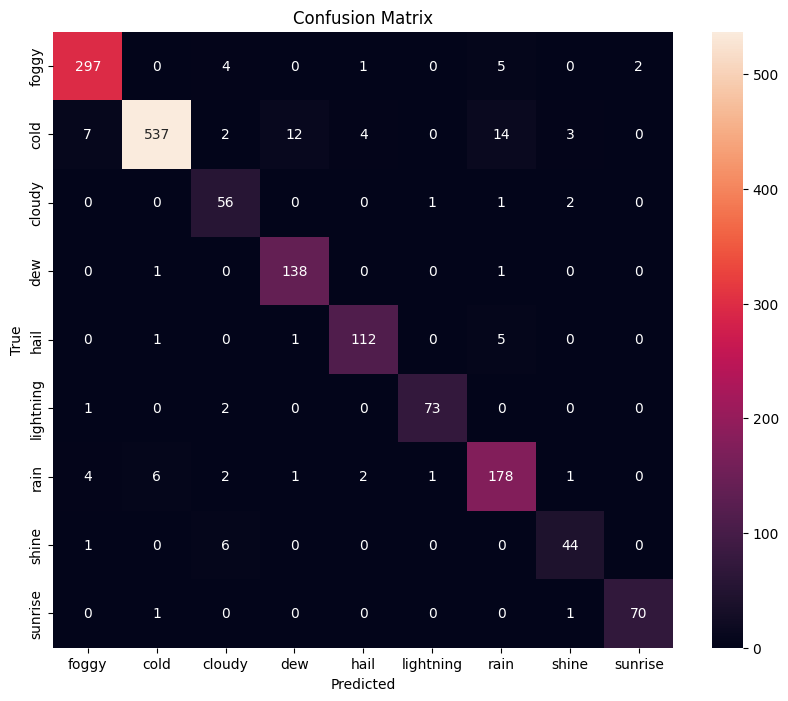

In [ ]:
labels, preds, probs = get_predictions_and_probs(model, val_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=list(grouped_classes.keys()), yticklabels=list(grouped_classes.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Precision and Recall:
Macro Precision: 0.9166
Macro Recall: 0.9397
Weighted Precision: 0.9428
Weighted Recall: 0.9400

Per-class Metrics:
              precision    recall  f1-score   support

       foggy       0.96      0.96      0.96       309
        cold       0.98      0.93      0.95       579
      cloudy       0.78      0.93      0.85        60
         dew       0.91      0.99      0.95       140
        hail       0.94      0.94      0.94       119
   lightning       0.97      0.96      0.97        76
        rain       0.87      0.91      0.89       195
       shine       0.86      0.86      0.86        51
     sunrise       0.97      0.97      0.97        72

    accuracy                           0.94      1601
   macro avg       0.92      0.94      0.93      1601
weighted avg       0.94      0.94      0.94      1601


AUC Scores:
AUC for foggy: 0.9967
AUC for cold: 0.9958
AUC for cloudy: 0.9948
AUC for dew: 0.9992
AUC for hail: 0.9990
AUC for lightning: 0.9998
AUC for rai

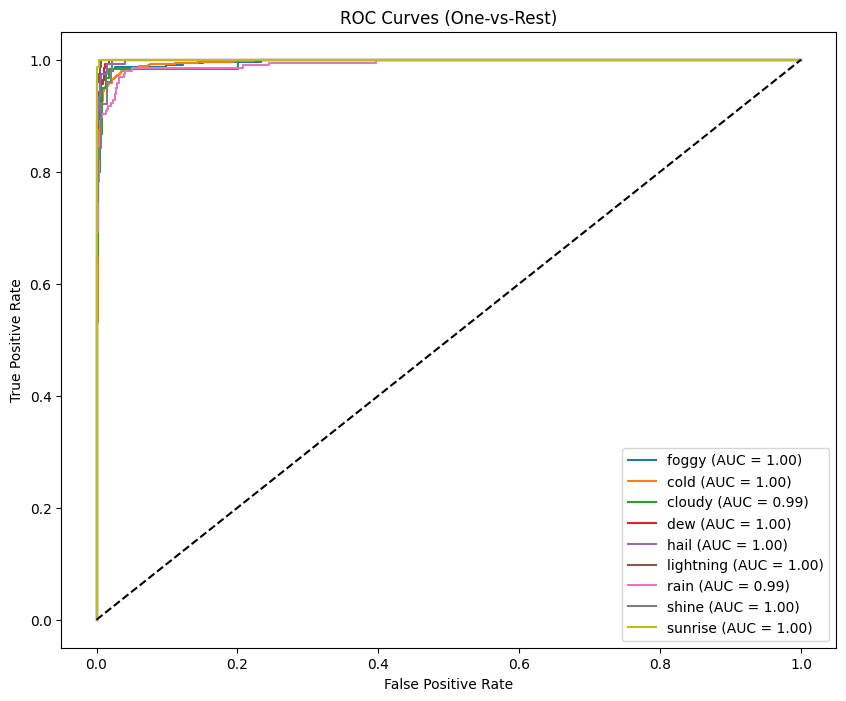

In [ ]:
# Precision and Recall
print("Precision and Recall:")
print(f"Macro Precision: {precision_score(labels, preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(labels, preds, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(labels, preds, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(labels, preds, average='weighted'):.4f}")
print("\nPer-class Metrics:")
print(classification_report(labels, preds, target_names=original_dataset.classes))

# AUC
labels_bin = label_binarize(labels, classes=range(num_classes))
auc_per_class = [roc_auc_score(labels_bin[:, i], probs[:, i]) for i in range(num_classes)]
macro_auc = roc_auc_score(labels_bin, probs, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(labels_bin.ravel(), probs.ravel())

print("\nAUC Scores:")
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {original_dataset.classes[i]}: {auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")
print(f"Micro-average AUC: {micro_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'{original_dataset.classes[i]} (AUC = {auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

In [ ]:
torch.save(model, '/kaggle/working/hierarchical_model.pth')